In [1]:
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import ast
import random
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd

In [2]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

from utils import *

class_mappings = get_class_mappings()
labels = get_imagenet_labels()
image_paths = get_image_paths()

In [3]:
model = models.resnet50(pretrained=True)
model.eval()
crop_errors = pd.read_csv("../results/possible_errors_results.csv")
crop_errors[:3]

,error,crop corr,target,pred,ratio,image file,target imagenet class,target class name,pred imagenet class,pred class name,index,valid
0,2783,4,39,90,0.501158,/home/lisa/data/imagenet-a/n02106550/0.000190_...,234,Rottweiler,456,bow,0,OK
1,2784,4,39,68,4.581006,/home/lisa/data/imagenet-a/n02106550/0.000342_...,234,Rottweiler,347,bison,1,INVALID
2,2794,4,39,85,0.506504,/home/lisa/data/imagenet-a/n02106550/0.004504_...,234,Rottweiler,428,wheelbarrow,2,INVALID


In [4]:
human_eval = pd.read_csv('../final_results.csv')
human_eval

,index,file,valid
0,1,/Users/lisadunlap/data/imagenet-a/n02106550/0....,INVALID
1,2,/Users/lisadunlap/data/imagenet-a/n02106550/0....,INVALID
2,3,/Users/lisadunlap/data/imagenet-a/n02106550/0....,INVALID
3,index,file,valid
4,index,file,valid
...,...,...,...
403,403,/Users/lisadunlap/data/imagenet-a/n11879895/0....,INVALID
404,404,/Users/lisadunlap/data/imagenet-a/n11879895/0....,INVALID
405,405,/Users/lisadunlap/data/imagenet-a/n12144580/0....,INVALID
406,index,file,valid


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
test_transform = transforms.Compose([transforms.Resize(256),
                            transforms.FiveCrop(224), # this is a list of PIL Images
                            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                            transforms.Normalize(mean, std)
                           ])

In [6]:
example = crop_errors.iloc[11]
image, target_imagenet_cls = Image.open(example['image file']), int(example['target imagenet class'])
inputs = test_transform(image)
cams = []
displ_imgs = []
for inp in inputs:
    cams.append(get_cam_tensor(inp, model, target_imagenet_cls, normalize=False)[0, :])
    displ_imgs.append(get_displ_img(inp))

/home/lisa/anaconda3/envs/ndv/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


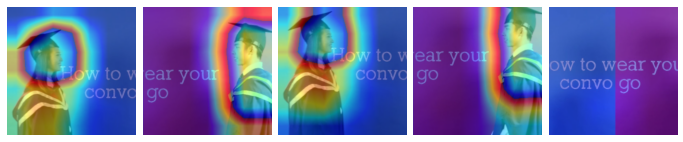

In [7]:
gcams = [show_cam_on_image(img/np.max(img), cam, use_rgb=True) for img, cam in zip(displ_imgs, cams)]

fig = plt.figure(figsize=(12., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, gcams):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()

In [8]:
middle_cam = cams[4]
print([np.max(c)/np.max(middle_cam) for c in cams])

[15.543328, 16.478115, 14.92596, 16.028719, 1.0]


In [9]:
def detect_crop(example):
    image, target_imagenet_cls = Image.open(example['image file']), int(example['target imagenet class'])
    inputs = test_transform(image.convert(mode='RGB'))
    cams = [get_cam_tensor(inp, model, target_imagenet_cls, normalize=False)[0, :] for inp in inputs]
    middle_cam = cams[4]
    if any([np.max(c)/np.max(middle_cam) > 5 for c in cams]):
        return True
    return False

In [10]:
results = {}
i = 0
for i, row in crop_errors.iterrows():
    results[i] = detect_crop(row)

In [11]:
res = pd.DataFrame([k for k in results.items()])
res.columns = ["index", "saliency guess"]
res

,index,saliency guess
0,0,False
1,1,True
2,2,True
3,3,False
4,4,False
...,...,...
403,403,False
404,404,True
405,405,False
406,406,False


In [12]:
rr = pd.merge(crop_errors, res, on="index")
rr[["valid", "saliency guess"]].to_csv("gradcam_check.csv", index=False)

In [17]:
data = pd.read_csv("gradcam_check.csv")
data[:5]

,valid,saliency guess
0,OK,False
1,INVALID,True
2,INVALID,True
3,INVALID,False
4,OK,False


In [19]:
def gen_gt(x):
    if x == "OK":
        return False
    else:
        return True
    
data["GT"] = data["valid"].apply(gen_gt)

In [22]:
from sklearn.metrics import f1_score

f1_score(data["GT"], data["saliency guess"], average='micro')

0.625